In [74]:
import pandas as pd
import re
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import joblib


In [75]:
import spacy
nlp = spacy.load("en_core_web_sm")


In [ ]:

df = pd.read_csv('combined_resumes.csv')

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Job Role     750 non-null    object
 1   Resume Text  750 non-null    object
dtypes: object(2)
memory usage: 11.8+ KB


In [78]:
df.isna().sum()

Job Role       0
Resume Text    0
dtype: int64

In [79]:
df.duplicated().sum()

np.int64(29)

In [80]:
df["Job Role"].value_counts()

Job Role
Data Scientist                    145
Software Engineer                 142
Data Engineer                     141
Data Analyst                      141
Ml Engineer                       130
ML Engineer                        13
Data Engineer Fresher               9
Data Analyst Fresher                9
Software Engineer Fresher           8
ML Engineer Fresher                 7
Data Scientist – Accenture          1
Data Scientist – Quantzig           1
Data Scientist – Guidehouse         1
Data Scientist – Contract Role      1
Data Scientist                      1
Name: count, dtype: int64

In [81]:
df['Job Role'] = df['Job Role'].str.replace(r'^Data Scientist.*', 'Data Scientist', regex=True)
df['Job Role'] = df['Job Role'].str.replace(r'^Data Analyst.*', 'Data Analyst', regex=True)
df['Job Role'] = df['Job Role'].str.replace(r'^Data Engineer.*', 'Data Engineer', regex=True)
df['Job Role'] = df['Job Role'].str.replace(r'^Software Engineer.*', 'Software Engineer', regex=True)
df['Job Role'] = df['Job Role'].str.replace(r'^ML Engineer.*', 'ML Engineer', regex=True)
df['Job Role'] = df['Job Role'].str.replace(r'Ml Engineer', 'ML Engineer', regex=True)

In [82]:


def spacy_preprocess(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha
    ]
    return " ".join(tokens)


In [ ]:

df['Cleaned_Resume'] = df['Resume Text'].apply(spacy_preprocess)

In [ ]:

tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['Cleaned_Resume']).toarray()


le = LabelEncoder()
y = le.fit_transform(df['Job Role'])


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [86]:
model= LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [87]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))



Accuracy: 0.9666666666666667


In [88]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98        27
           1       1.00      1.00      1.00        31
           2       0.87      1.00      0.93        27
           3       1.00      0.88      0.94        26
           4       1.00      0.95      0.97        39

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



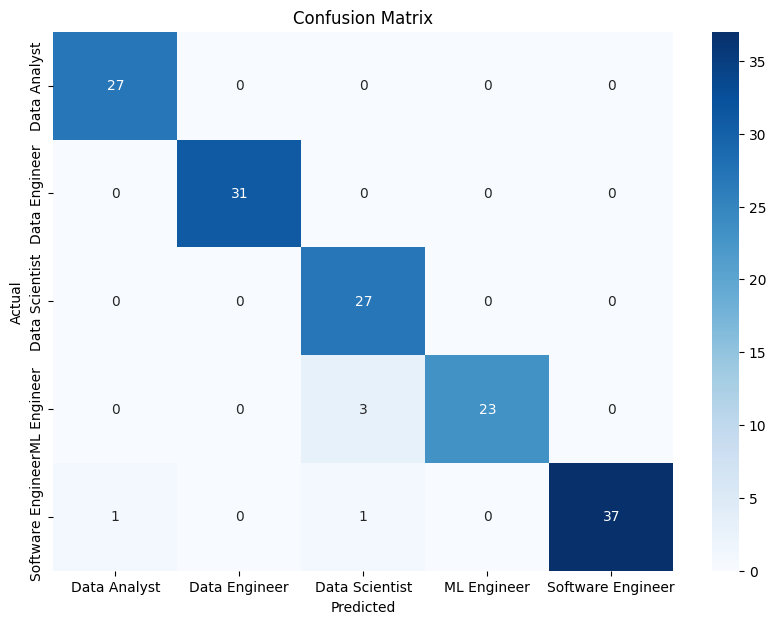

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [90]:
df["Job Role"].value_counts()

Job Role
Data Engineer        150
ML Engineer          150
Software Engineer    150
Data Scientist       150
Data Analyst         150
Name: count, dtype: int64

In [ ]:

joblib.dump(model, "job_role_predictor.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

In [92]:
import numpy as np

In [93]:
def predict_roles(text):
    cleaned = spacy_preprocess(text)
    X_input = tfidf.transform([cleaned]).toarray()
    probs = model.predict_proba(X_input)[0]
    
    results = []
    for i, prob in enumerate(probs):
        if prob > 0.25:
            role = le.inverse_transform([i])[0]
            results.append((role, prob))
    
    return results


In [ ]:

role_skills_map = {
    "data scientist": {"python", "sql", "tableau", "machine learning", "numpy", "pandas", "scikit-learn", "matplotlib", "seaborn"},
    "data engineer": {"python", "sql", "etl", "hadoop", "spark", "aws", "azure", "airflow", "bigquery", "data warehousing"},
    "software engineer": {"python", "java", "c++", "data structures", "algorithms", "git", "sql", "api", "docker"},
    "data analyst": {"excel", "sql", "tableau", "powerbi", "data visualization", "python", "statistics", "matplotlib", "seaborn"},
    "ml engineer": {"python", "tensorflow", "keras", "scikit-learn", "numpy", "pandas", "mlops", "docker", "git", "opencv"}
}

In [95]:
master_skills = set().union(*role_skills_map.values())

In [96]:
def extract_skills(text, skills_vocab):
    doc = nlp(text.lower())
    tokens = set(token.text for token in doc if token.is_alpha)
    return tokens & skills_vocab




In [97]:
def generate_course_links(skill):
    query = skill.replace(" ", "+")
    return {
        "Coursera": f"https://www.coursera.org/search?query={query}",
        "Udemy": f"https://www.udemy.com/courses/search/?q={query}",
        "YouTube": f"https://www.youtube.com/results?search_query={query}+tutorial"
    }

In [98]:
def get_learning_resources_for_missing_skills(missing_skills):
    return {skill: generate_course_links(skill) for skill in missing_skills}

In [99]:
def analyze_job_role_skills(resume_text, job_role):
    required_skills = role_skills_map.get(job_role.lower(), set())
    resume_skills = extract_skills(resume_text, master_skills)
    missing_skills = required_skills - resume_skills
    matched_skills = required_skills & resume_skills
    score = (len(matched_skills) / len(required_skills)) * 100 if required_skills else 0
    resources = get_learning_resources_for_missing_skills(missing_skills)
    return {
        "required_skills": list(required_skills),
        "resume_skills": list(resume_skills),
        "matched_skills": list(matched_skills),
        "missing_skills": list(missing_skills),
        "score": round(score, 2),
        "resources": resources
    }

In [100]:
def analyze_jd_skills(resume_text, jd_text):
    resume_skills = extract_skills(resume_text, master_skills)
    jd_skills = extract_skills(jd_text, master_skills)
    missing_skills = jd_skills - resume_skills
    matched_skills = jd_skills & resume_skills
    score = (len(matched_skills) / len(jd_skills)) * 100 if jd_skills else 0
    resources = get_learning_resources_for_missing_skills(missing_skills)
    return {
        "jd_skills": list(jd_skills),
        "resume_skills": list(resume_skills),
        "matched_skills": list(matched_skills),
        "missing_skills": list(missing_skills),
        "score": round(score, 2),
        "resources": resources
    }

In [101]:


def ats_score_10_point_without_jd(resume_text):
    score = 0
    details = {}

    lower_resume = resume_text.lower()
    has_email = re.search(r'[\w\.-]+@[\w\.-]+', resume_text)
    has_phone = re.search(r'\b\d{10}\b|\+\d{2,3}[-\s]?\d{10}', resume_text)

    if not re.search(r'<table|<img', resume_text):
        score += 1
        details['Simple Formatting'] = 1
    else:
        details['Simple Formatting'] = 0

    if has_email or has_phone:
        score += 1
        details['Contact Info'] = 1
    else:
        details['Contact Info'] = 0

    predicted_role = predict_roles(resume_text, n=1)[0][0]
    expected_skills = role_skills_map.get(predicted_role.lower(), set())
    resume_skills = extract_skills(resume_text, master_skills)
    matched_keywords = expected_skills & resume_skills
    if matched_keywords:
        score += 2
        details['Job-Relevant Keywords'] = 2
    else:
        details['Job-Relevant Keywords'] = 0

    if 'skills' in lower_resume and resume_skills:
        score += 2
        details['Technical Skills Listed'] = 2
    else:
        details['Technical Skills Listed'] = 0

    if 'education' in lower_resume:
        score += 1
        details['Education Section'] = 1
    else:
        details['Education Section'] = 0

    if 'project' in lower_resume or 'experience' in lower_resume:
        score += 2
        details['Projects/Experience'] = 2
    else:
        details['Projects/Experience'] = 0

    standard_sections = ['summary', 'skills', 'education', 'projects', 'experience']
    found_sections = [sec for sec in standard_sections if sec in lower_resume]
    if len(found_sections) >= 3:
        score += 1
        details['Standard Sections Used'] = 1
    else:
        details['Standard Sections Used'] = 0

    details['Total ATS Score (out of 10)'] = score
    return details


In [ ]:
resume_text = """Name: Priya Singh Contact: LinkedIn Profile | priya.singh.ds@email.com
Summary Highly motivated a with a strong academic background in Computer Science. Proficient in Python, SQL, and data visualization tools. Eager to apply problem-solving skills and a detail-oriented approach to extract insights from complex datasets and drive data-driven decision-making.
EducationBachelor of Technology in Computer Science IIT Bombay, Mumbai 2025
Technical Skills
• Languages: Python (Pandas, NumPy, Scikit-learn, Matplotlib, Seaborn), SQL
• Data Analysis: EDA, Statistical Analysis, Hypothesis Testing, Feature Engineering, A/B Testing (basic)
• Machine Learning: Regression, Classification, Clustering, Model Evaluation
• Tools: Jupyter Notebooks, Git, Tableau (basic)
Projects
• Customer Churn Prediction: Developed a classification model in Python to predict customer churn for a telecom company using historical usage data. Performed extensive EDA and feature engineering, demonstrating analytical thinking in identifying key churn indicators and attention to detail in data preprocessing.
• E-commerce Sales Performance Analysis: Conducted a comprehensive analysis of e-commerce sales data using Python and SQL. Identified top-performing products, customer segments, and regional trends, showcasing communication skills by presenting actionable insights through visualizations in Tableau.
Certifications
• Google Data Analytics Professional Certificate
• Machine Learning for Data Science (Coursera)"""
jd_text = """Looking for a Data Scientist skilled in Python, SQL, Tableau, A/B testing,algorithms and machine learning"""


top_roles = predict_roles(resume_text)
print("Top predicted roles and scores:")
for role, score in top_roles:
    print(f"{role}: {score*100:.2f}%")




target_role = "Data Scientist"
analysis = analyze_job_role_skills(resume_text, target_role)

print(f"\n🔍 Analysis for Target Role: {target_role}")
print(f"✅ Matched Skills: {analysis['matched_skills']}")
print(f"❌ Missing Skills: {analysis['missing_skills']}")
print(f"📈 Match Score: {analysis['score']}%")

print("\n📚 Learning Resources for Missing Skills:")
for skill, links in analysis['resources'].items():
    print(f"\n🔸 {skill.title()}:")
    for platform, url in links.items():
        print(f"   - {platform}: {url}")    



jd_analysis = analyze_jd_skills(resume_text, jd_text)

print("📄 JD–Resume Skill Analysis")
print(f"✅ Matched Skills: {jd_analysis['matched_skills']}")
print(f"❌ Missing Skills: {jd_analysis['missing_skills']}")
print(f"📊 Skill Match Score: {jd_analysis['score']}%")

print("\n📚 Learning Resources for Missing Skills:")
for skill, links in jd_analysis['resources'].items():
    print(f"\n🔸 {skill.title()}:")
    for platform, url in links.items():
        print(f"   - {platform}: {url}")


Top predicted roles and scores:
Data Analyst: 26.62%
Data Scientist: 56.96%

🔍 Analysis for Target Role: Data Scientist
✅ Matched Skills: ['matplotlib', 'pandas', 'sql', 'tableau', 'numpy', 'python', 'seaborn']
❌ Missing Skills: ['scikit-learn', 'machine learning']
📈 Match Score: 77.78%

📚 Learning Resources for Missing Skills:

🔸 Scikit-Learn:
   - Coursera: https://www.coursera.org/search?query=scikit-learn
   - Udemy: https://www.udemy.com/courses/search/?q=scikit-learn
   - YouTube: https://www.youtube.com/results?search_query=scikit-learn+tutorial

🔸 Machine Learning:
   - Coursera: https://www.coursera.org/search?query=machine+learning
   - Udemy: https://www.udemy.com/courses/search/?q=machine+learning
   - YouTube: https://www.youtube.com/results?search_query=machine+learning+tutorial
📄 JD–Resume Skill Analysis
✅ Matched Skills: ['sql', 'tableau', 'python']
❌ Missing Skills: ['algorithms']
📊 Skill Match Score: 75.0%

📚 Learning Resources for Missing Skills:

🔸 Algorithms:
   - 

In [103]:
# resume_text = """
# Name: Priya Sharma
# Email: priyasharma.dev@email.com
# Phone: +91-9876543210
# LinkedIn: linkedin.com/in/priyasharma-dev
# GitHub: github.com/priyasharma-dev
# Location: Bengaluru, India

# 🎯 Career Objective
# Motivated and detail-oriented Computer Science graduate with strong problem-solving skills and a passion for building software solutions. Eager to apply my knowledge of programming, data structures, and software engineering principles to contribute to high-impact development projects.

# 🎓 Education
# B.Tech in Computer Science and Engineering
# ABC Institute of Technology, Bengaluru
# 2019 – 2023 | CGPA: 8.2/10

# Higher Secondary Education (Class XII)
# Sunrise Public School, Bengaluru | 2017 – 2019 | 90%

# 💻 Technical Skills
# Languages: Python, Java, C

# Web Development: HTML, CSS, JavaScript

# Frameworks/Tools: React.js (Basics), Git, Visual Studio Code

# Database: MySQL, SQLite

# Other Tools: GitHub, Postman, VS Code, Figma (basic)

# Platforms: Windows, Linux

# 🛠️ Projects
# 1. AR Wheel Try-On (AR Application)
# Tech Stack: Unity, C#, Blender

# Built an augmented reality mobile app to visualize alloy wheels on vehicles in real time

# Modeled 3D wheels using Blender and integrated them into Unity

# Used AR Foundation to detect surfaces and place virtual objects

# Improved user decision-making during wheel purchases

# 2. Online Quiz Web App
# Tech Stack: HTML, CSS, JavaScript, Firebase

# Created a responsive web application for quizzes with user authentication

# Real-time score updates and time-based questions

# Hosted on Firebase with user result tracking

# 🏆 Certifications
# Microsoft Power Platform Fundamentals (PL-900)

# Responsive Web Design – freeCodeCamp

# Introduction to Python – Coursera

# 🧠 Soft Skills
# Quick learner

# Team player

# Attention to detail

# Effective communicator

# 📌 Achievements
# Top 5 finalist in the college-level Hackathon 2022

# Member of the Computer Society of India (CSI) – 2021–2022

# 📅 Availability
# Immediately available for full-time roles | Willing to relocate


# """

# top_roles = predict_top_n_roles(resume_text, n=3)
# print("Top predicted roles and scores:")
# for role, score in top_roles:
#     print(f"{role}: {score*100:.2f}%")